In [486]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from matplotlib import cm

def Raman_data_loader(filename):

    with h5py.File( filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number%Nx), int(spot_number//Nx)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties



In [487]:
filename = "2023811_1451.h5"
spectrum, wavelengths, exp_properties = Raman_data_loader( filename)

<IPython.core.display.Javascript object>


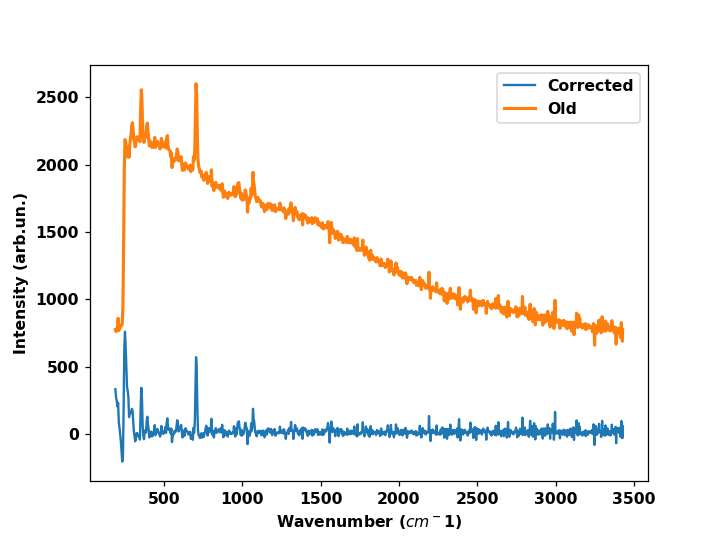

In [488]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

ix,iy = 10,10
##optimize parameters
lam = 1e2
p=1e-1
baseline = baseline_als_optimized(spectrum[ix,iy,:],lam=lam,p=p,niter=10)
fig,ax = plt.subplots()
plt.plot(wavelengths, spectrum[ix,iy,:] - baseline,label='Corrected')
plt.plot(wavelengths, spectrum[ix,iy,:], lw=2,label='Old')
ax.set_xlabel(r'Wavenumber $(cm^-1)$')
ax.set_ylabel(r'Intensity (arb.un.)')
ax.legend()

In [497]:
pro_data = 1*spectrum
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        print(i,j,end='\r')
        spec = 1 * pro_data[i,j, :]
        pro_data[i,j,:] = spec - baseline_als_optimized(spec,lam=lam,p=p,niter=10)

In [498]:
pro_data[:,:,:31] = 0

# 0. Analyze data

In [499]:
exp_properties

{'step_size': 0.4,
 'speed': array([b'5.000', b'5.000'], dtype=object),
 'n_points': array([50, 50])}

In [542]:
find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))

In [543]:
import pandas as pd

def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])



<IPython.core.display.Javascript object>


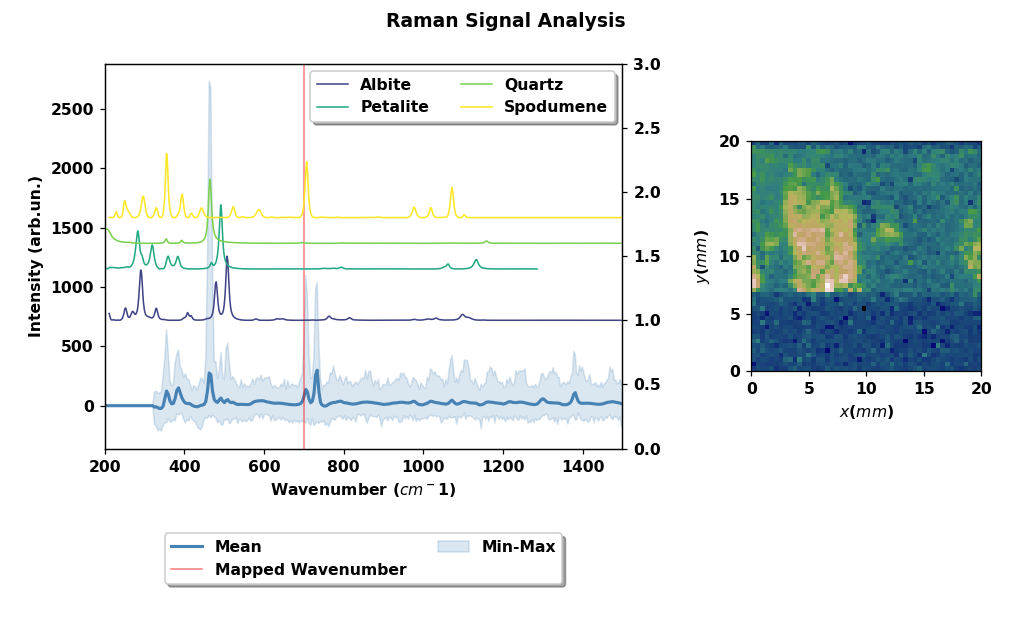

Albite
Background
Background not found
Petalite
Quartz
Spodumene


In [563]:
mean_signal = np.mean(pro_data, axis=(0,1))
min_signal = np.min(pro_data, axis=(0,1))
max_signal = np.max(pro_data, axis=(0,1))

fig,ax = plt.subplots(1,2,figsize=[8,5],gridspec_kw={'width_ratios':[0.9,0.4]})
fig.suptitle('Raman Signal Analysis')
ax[0].plot(wavelengths,mean_signal,lw=2,ls='-',color='steelblue',label='Mean')
ax[0].fill_between(wavelengths,min_signal,max_signal,color='steelblue',alpha=0.2,label='Min-Max')
wn=120
line = ax[0].axvline(wavelengths[wn],lw='1',alpha=0.5,color='red',label='Mapped Wavenumber')
ax[0].set_xlabel(r'Wavenumber $(cm^-1)$')
ax[0].set_ylabel(r'Intensity (arb.un.)')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=2, fancybox=True, shadow=True)

ax0 = ax[0].twinx()

minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())
for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        ax0.plot(wl, 1 + 0.2*i + 0.5 * spec/np.max(spec),lw=1,color=cm.viridis((i+1)/len(mineral_list)),label=mineral)
    except:
        print(mineral + ' not found')
ax0.set_ylim(0,1+0.2*(i+1)+1)
ax0.set_xlim(200,1500)
    
ax0.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),ncol=2, fancybox=True, shadow=True)
plt.sca(ax[0])



ax[1].imshow(pro_data[:,:,wn],cmap=cm.gist_earth,extent=[0,exp_properties['step_size']*exp_properties['n_points'][0],
                                                        0,exp_properties['step_size']*exp_properties['n_points'][1]])
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


def update_map(wn):
    im = ax[1].imshow(pro_data[:,:,wn],cmap=cm.inferno,
                      extent=[0,exp_properties['step_size']*exp_properties['n_points'][0],
                            0,exp_properties['step_size']*exp_properties['n_points'][1]],
                     interpolation='gaussian')
    line.set_xdata(wavelengths[wn])

def onclick(event):
    ix, iy = event.xdata, event.ydata
    wn = find_index(wavelengths,ix)
    if event.inaxes == ax[0] or event.inaxes == ax0:
        update_map(wn)
        fig.canvas.draw_idle()
        
cid = fig.canvas.mpl_connect('button_press_event', onclick)


fig.tight_layout()

# 1. Unsupervised Classifier

# 1.1 Feature extraction

In [564]:

features = []
radius = 2

for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    new_array = pro_data[:,:,wn-radius:wn+radius].mean(axis=-1)
    #features.append(new_array)#/np.max(new_array))
    features.append( ( new_array - np.min(new_array) ) / (np.max(new_array)-np.min(new_array)))
    
features = np.transpose(np.array(features),axes=(1,2,0))
features = features.reshape([features.shape[0]*features.shape[1],features.shape[2]])

initial_mineral_list = mineral_list

In [565]:
features

array([[0.16104435, 0.92380531, 0.32380049, 0.02262851, 0.02942873],
       [0.18524711, 0.9086841 , 0.3533091 , 0.033037  , 0.03650462],
       [0.23929594, 0.91362154, 0.32774348, 0.02215192, 0.01858263],
       ...,
       [0.22467968, 0.93611718, 0.2634561 , 0.04511239, 0.01099645],
       [0.15850676, 0.89987894, 0.25174802, 0.02098042, 0.02157501],
       [0.15187495, 0.89402785, 0.2649981 , 0.01635565, 0.02662181]])

# 1.2 Number of Clusters

<IPython.core.display.Javascript object>


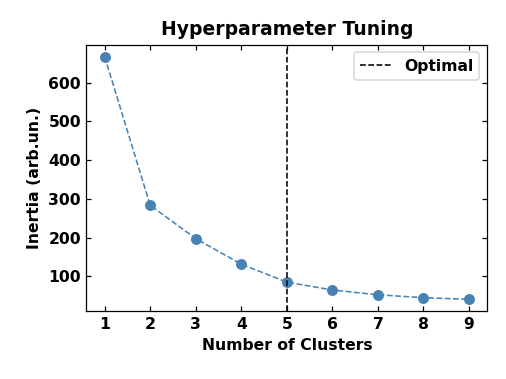

In [566]:
import sklearn

ncs = [i for i in range(1,10)]
inertias = []
for n_clusters in ncs:
    model = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=0)
    model.fit(features)
    inertias.append(model.inertia_)

fig,ax = plt.subplots(figsize=[4,3])
ax.set_title('Hyperparameter Tuning')
ax.plot(ncs, inertias, marker = 'o', color='steelblue', lw=1,ls='--')
ax.axvline(5,color='k',lw=1,ls='--',label='Optimal')
ax.legend()
ax.set_xlabel('Number of Clusters')
ax.set_xticks(ncs)
ax.set_ylabel('Inertia (arb.un.)')
ax.tick_params(axis='both',direction="in",top=True,right=True)
fig.tight_layout()


# 1.3 Training Unsupervised Classification

In [575]:
n_clusters = 5

# Cluster centers already initialized to match those of the predicted features
#ALBITE; BACKGROUND; PETALITE; QUARTZ; SPODUMENE
clusters_init = [ [1,0,0,0,0], 
                 [0,1,0,0,0],
                 [0,0,1,0,0],
                 [0,0,0,1,0],
                 [0,0,0,0,1]
                ]

model = sklearn.cluster.KMeans(n_clusters=n_clusters, init = np.array(clusters_init), random_state=100)
model.fit(features)
predictions = model.predict(features)

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


# 1.3.1 RAMAN MAPS

<IPython.core.display.Javascript object>


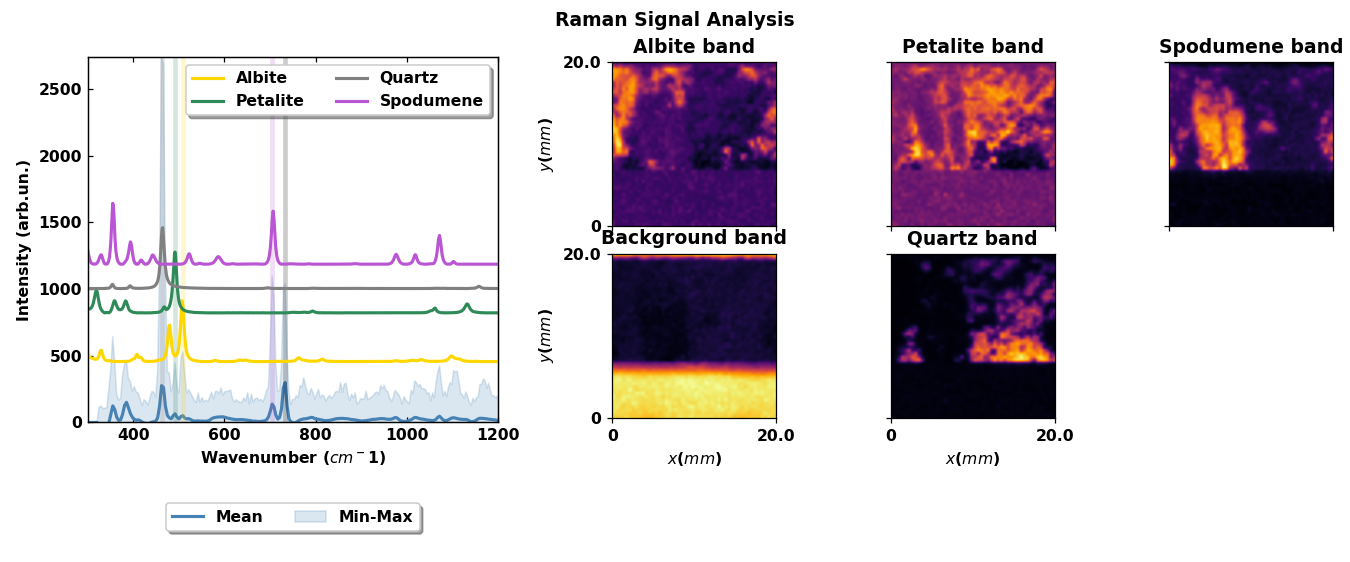

Albite
Background
Raman Spectra for Background not found
Petalite
Quartz
Spodumene


In [577]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


mean_signal = np.mean(pro_data, axis=(0,1))
min_signal = np.min(pro_data, axis=(0,1))
max_signal = np.max(pro_data, axis=(0,1))

colors = ['gold','k','seagreen','grey','mediumorchid']
cmp1 = ListedColormap(colors[:n_clusters])

minerals = {
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5],
}

mineral_list = list(minerals.keys())

fig = plt.figure(figsize=[12,5])

gs = GridSpec(2, 1+len(mineral_list)//2+len(mineral_list)%2, figure=fig, width_ratios = [0.5]+ (len(mineral_list)//2+len(mineral_list)%2) * [0.2])
ax = []
ax.append(fig.add_subplot(gs[:, 0]))
ax+= [fig.add_subplot(gs[i%2, 1+i//2]) for i in range(0,len(mineral_list))]

fig.suptitle('Raman Signal Analysis')
ax[0].plot(wavelengths,mean_signal,lw=2,ls='-',color='steelblue',label='Mean')
ax[0].fill_between(wavelengths,min_signal,max_signal,color='steelblue',alpha=0.2,label='Min-Max')

ax[0].set_xlabel(r'Wavenumber $(cm^-1)$')
ax[0].set_ylabel(r'Intensity (arb.un.)')
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),ncol=2, fancybox=True, shadow=True)
ax[0].set_ylim(0,np.max(max_signal))
ax[0].tick_params(axis='both',direction="in",top=True,right=True)
ax0 = ax[0].twinx()


for i,mineral in enumerate(mineral_list):
    print(mineral)
    try:
        wl,spec = read_ref(mineral)
        ax0.plot(wl, 0.5 + 0.2*i + 0.5 * spec/np.max(spec),lw=2,color=cmp1((i)/len(mineral_list)),label=mineral)
    except:
        print('Raman Spectra for ' + (mineral) + ' not found')
    wn=find_index(wavelengths,minerals[mineral][0])
    ax[0].axvline(wavelengths[wn],lw=3,alpha=0.2,color=cmp1((i)/len(mineral_list)))
    
    ax[i+1].set_title(mineral + ' band')
    Lx = exp_properties['step_size']*exp_properties['n_points'][0]
    Ly = exp_properties['step_size']*exp_properties['n_points'][1]
    radius = 2
    ax[i+1].imshow(pro_data[:,:,wn-radius:wn+radius].mean(axis=-1),cmap=cm.inferno,
                   extent=[0,Lx,0,Ly], 
                   interpolation='gaussian')
    
    if i%2 == 0:
        ax[i+1].set_xlabel(r'')
        ax[i+1].set_xticks([0,Lx])
        ax[i+1].set_xticklabels(['',''])
    else:
        ax[i+1].set_xlabel(r'$x(mm)$')
        ax[i+1].set_xticks([0,Lx])
        ax[i+1].set_xticklabels([0,Lx])
        
    if i//2 == 0:
        ax[i+1].set_ylabel(r'$y(mm)$')
        ax[i+1].set_yticks([0,Ly])
        ax[i+1].set_yticklabels([0,Ly])
    else:
        ax[i+1].set_ylabel(r'')
        ax[i+1].set_yticks([0,Ly])
        ax[i+1].set_yticklabels(['',''])

        

    
ax0.set_ylim(0,1+0.2*(i+1)+1)
ax0.set_xlim(300,1200)
ax0.set_yticks([])
    
ax0.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0),ncol=2, fancybox=True, shadow=True)

fig.tight_layout()
plt.savefig('Raman_map_bands.png',dpi=300)

<IPython.core.display.Javascript object>


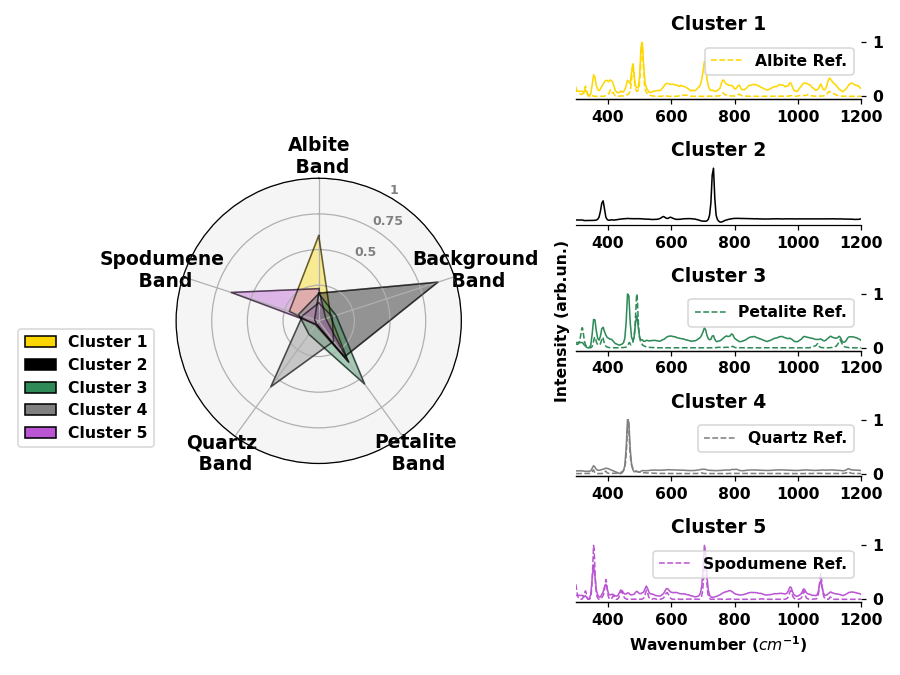

[0.59786197 0.08865244 0.35174251 0.03599431 0.21656378]
gold 0
[0.19449354 0.87854346 0.31035888 0.02731904 0.03050439]
k 1
[0.19020754 0.12712426 0.54712209 0.1162206  0.14792705]
seagreen 2
[0.12597304 0.09938412 0.17703464 0.57121864 0.11881922]
grey 3
[0.22605511 0.05182639 0.35989966 0.02844475 0.64498198]
mediumorchid 4


In [578]:
N = len(mineral_list)
categories =[ i + '\n Band' for i in list(initial_mineral_list)]

# minerals = {
#     'Petalite':[491.3],
#     'Quartz':[463.92],
#     'Spodumene':[704.5],
#     'Albite':[508.1],
#     'Background':[733.1]}

cluster_list = ['Cluster ' + str(i+1) for i in range(0,N)]
cmp1 = ListedColormap(colors[:n_clusters])



angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=[8,6])

G = GridSpec(n_clusters,2,width_ratios = [0.5,0.5])
ax = [fig.add_subplot(G[:,0],polar=True)]+[fig.add_subplot(G[i,1]) for i in range(0, n_clusters)]

# If you want the first axis to be on top:
ax[0].set_theta_offset(np.pi / 2)
ax[0].set_theta_direction(-1)
 
# Draw one axe per variable + add labels
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(categories,size=12)
 
# Draw ylabels
ax[0].set_rlabel_position(30)
ax[0].set_yticks([0,0.25,0.5,0.75,1])
ax[0].set_yticklabels(["0","","0.5","0.75","1"], size=8,c='grey')
ax[0].set_ylim(0,1.0)
 

# Ind1
iis = [0,1,2,3,4]

pro_data_flat = pro_data.reshape((pro_data.shape[0]*pro_data.shape[1],-1))
for i in iis:
    center = model.cluster_centers_[i]
    print(center)
    values=[center[j] for j in range(0,N)]
    values += values[:1]
    ax[0].plot(angles, values,color='k',lw=1,alpha=0.6,ls='-') #, label=minerals[i]
    print(colors[i],i)
    ax[0].fill(angles, values, color=colors[i], alpha=0.4)
    
    cluster_index = np.where(predictions == i)[0]
    try:
        mineral = mineral_list[i]
        wl,spec = read_ref(mineral)
        ax0 = ax[i+1].twinx()
        ax0.plot(wl, spec/np.max(spec),
                lw=1,
                color=colors[i], 
                ls='--',label=mineral+ ' Ref.' )
        ax0.legend(loc=1)
        ax0.spines['top'].set_visible(False)
        ax0.spines['right'].set_visible(False)
        ax0.spines['left'].set_visible(False)
    except:
        pass
    
        
    ax[i+1].set_title('Cluster ' + str(i+1))
    ax[i+1].plot(wavelengths, np.mean(pro_data_flat[cluster_index], axis=(0)),lw=1,color=colors[i])
    ax[i+1].set_xlim(300,1200)
    ax[i+1].set_yticks([])
    
    ax[i+1].spines['top'].set_visible(False)
    ax[i+1].spines['right'].set_visible(False)
    ax[i+1].spines['left'].set_visible(False)
    
    if i == iis[-1]:
        ax[i+1].set_xlabel(r'Wavenumber $(cm^{-1})$')
    if i == 2:
        ax[i+1].set_ylabel('Intensity (arb.un.)')
        
    
ax[0].set_facecolor("whitesmoke")
# Add legend
hls = []
for color,cluster in zip(colors,cluster_list):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)
ax[0].legend(handles=hls,loc = 'upper right',  bbox_to_anchor=(-0.05, 0.5),ncol=1)


fig.tight_layout()
plt.savefig('cluster_assignment_map.png',dpi=300)

<IPython.core.display.Javascript object>


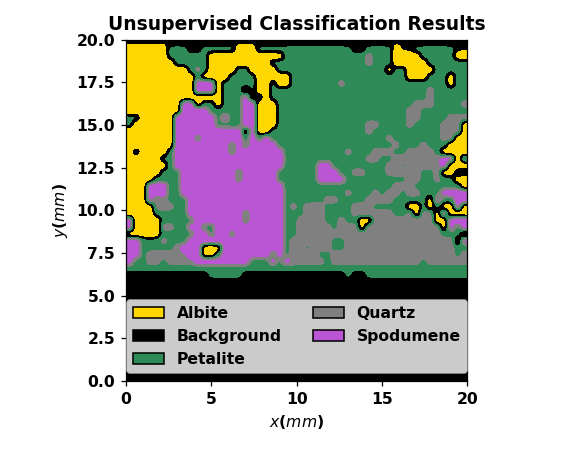

In [572]:
fig,ax = plt.subplots(1,1,figsize=[5,4])
plt.imshow(predictions.reshape(pro_data.shape[0],pro_data.shape[1]),
           cmap=cmp1,extent=[0,Lx,0,Ly],interpolation='gaussian')

hls=[]
for color,cluster in zip(colors,mineral_list):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)

ax.set_title('Unsupervised Classification Results')
ax.legend(handles=hls,loc = 'lower center',  bbox_to_anchor=(0.5, 0),ncol=2)
ax.set_xlabel(r'$x(mm)$')
ax.set_ylabel(r'$y(mm)$')
fig.tight_layout()
plt.savefig('Classification_map.png',dpi=300)